# Import modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import time

# Set device

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.xpu.is_available():
    device = torch.device('xpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Prepare datasets

In [3]:
# Load data and split to training, validation and test data
image_data = ImageFolder('ball-images', transform=transforms.ToTensor())
label_indices = image_data.class_to_idx
training_data, validation_data, test_data = random_split(image_data, [0.7, 0.1, 0.2], generator=torch.Generator().manual_seed(42))
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [18]:
label_indices

{'croquet_ball': 0,
 'golf_ball': 1,
 'ping_pong_ball': 2,
 'rugby_ball': 3,
 'soccer_ball': 4,
 'tennis_ball': 5}

Text(0.5, 1.0, 'tennis_ball')

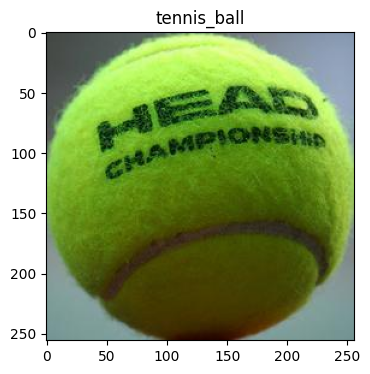

In [4]:
# Show a random example image with textual label
example_images, example_labels = next(iter(training_loader))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.imshow(np.transpose(example_images[0], (1, 2, 0)))
text_label = [key for key, val in label_indices.items() if val == example_labels[0]]
ax.set_title(text_label[0])

# Define CNN model class

In [ ]:
class BallClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        self.fc_block = nn.Sequential(
            nn.Linear(in_features=9216, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=1024, out_features=len(label_indices))
        )
    
    def forward(self, input):
        conv_1 = self.conv_block_1(input)
        conv_2 = self.conv_block_2(conv_1)
        conv_3 = self.conv_block_3(conv_2)
        # print(conv_3.shape)
        flattened = conv_3.view(conv_3.size(0), -1)
        output = self.fc_block(flattened)
        return output

# Define loss criterion and optimizer

In [33]:
model = BallClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)

model = model.to(device)
criterion = criterion.to(device)

# Train & test the model

In [ ]:
def test_model(model, criterion, test_dataloader):
    model.eval()
    with torch.no_grad():
        total_loss, correct_predictions = 0., 0.
        for i, (input_batch, target_batch) in enumerate(test_dataloader):

            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            output = model(input_batch)
            total_loss += criterion(output.squeeze(-1), target_batch).item()
            predictions = torch.argmax(output, dim=1) # Get index label with highest value after softmax calculation in CE loss function

            correct_predictions += (predictions == target_batch).sum().item()

    # Average for all batches
    average_loss = total_loss / (i + 1)  # Use i + 1 for the total number of batches
    average_accuracy = correct_predictions / len(test_dataloader.dataset)

    return average_loss, average_accuracy

In [ ]:
def train_model(n_epochs, model, criterion, optimizer, train_dataloader, val_dataloader, verbose=True, verbose_interval=1):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    model.train()
    for epoch in range(1, n_epochs + 1):
        start = time.time()
        train_loss, correct_predictions = 0., 0.

        for i, (input_batch, target_batch) in enumerate(train_dataloader):
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            output = model(input_batch)
            loss_train = criterion(output.squeeze(-1), target_batch)
            predictions = torch.argmax(output, dim=1) # Get index label with highest value after softmax calculation in CE loss function
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            # accumulate correct prediction
            correct_predictions += (predictions == target_batch).sum().item() # number of correct predictions
            train_loss += loss_train.item()

        average_train_loss = train_loss / (i+1)
        average_train_accuracy = correct_predictions / len(train_dataloader.dataset)

        val_loss, val_accuracy = test_model(model, criterion, val_dataloader)

        train_losses.append(average_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(average_train_accuracy)
        val_accuracies.append(val_accuracy)

        end = time.time()
        epoch_time = round(end - start, 2)
        if verbose and epoch % verbose_interval == 0:
            print(f'Epoch {epoch}: train_loss {average_train_loss:.3f}, train_accuracy: {average_train_accuracy:.4f},',
                  f'validation_loss {val_loss:.3f}, validation_accuracy: {val_accuracy:.4f}, time = {epoch_time}s')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [34]:
n_epochs = 30
train_losses, val_losses, train_accuracy, val_accuracy = train_model(n_epochs, model, criterion, optimizer, training_loader, validation_loader)
torch.save(model.state_dict(), 'ball_classifier_model.pth')
print("Your trained model is saved successfully!")

Epoch 1: train_loss 1.723, train_accuracy: 0.2781, validation_loss 1.801, validation_accuracy: 0.1972, time = 7.49s
Epoch 2: train_loss 1.726, train_accuracy: 0.2716, validation_loss 1.690, validation_accuracy: 0.4174, time = 7.07s
Epoch 3: train_loss 1.609, train_accuracy: 0.4306, validation_loss 1.540, validation_accuracy: 0.4312, time = 7.07s
Epoch 4: train_loss 1.439, train_accuracy: 0.4928, validation_loss 1.363, validation_accuracy: 0.5000, time = 7.0s
Epoch 5: train_loss 1.309, train_accuracy: 0.5295, validation_loss 1.275, validation_accuracy: 0.5183, time = 7.05s
Epoch 6: train_loss 1.204, train_accuracy: 0.5602, validation_loss 1.263, validation_accuracy: 0.5000, time = 7.03s
Epoch 7: train_loss 1.140, train_accuracy: 0.5870, validation_loss 1.196, validation_accuracy: 0.5596, time = 6.83s
Epoch 8: train_loss 1.063, train_accuracy: 0.6289, validation_loss 1.136, validation_accuracy: 0.5872, time = 6.53s
Epoch 9: train_loss 1.020, train_accuracy: 0.6401, validation_loss 1.103,

In [35]:
test_loss, test_accuracy = test_model(model, criterion, test_loader)
print(f'Test loss: {test_loss:.3f}; Test accuracy: {test_accuracy:.4f}')

Test loss: 1.004; Test accuracy: 0.6330
